# World Data League 2022

## 🎯 Challenge
**Predict Waste Production for its Reduction**

### Introduction

There is a significant impact from the logistical side of waste management in the environment [1]. Most of this impact is directly due to garbage trucks and other machinery emissions. However, a chain of costs is associated with operating this logistics network—road damage, road congestion, noise, and odor pollution impact both the environment and quality of life.

Therefore, it is crucial to optimize truck routing to cover as much ground as possible while requiring as little movement as possible, reducing the number of trucks on the road.

While this is a very complex problem to approach, our goal is to provide some of the tools required to optimize truck routes and understand where truck routes are being inefficient. This way, decision-makers can understand where the problem is located and act on it.

## 👥 Authors
* Rui Granja
* Pedro Ruas
* Tiago Neves
* Pedro Miguez

## 💻 Development

###1 - Importing libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error

In [ ]:
plt.style.use('fivethirtyeight')

### 2 - Importing data

We only use data from the Waste Collection dataset in this notebook.

We perform standard practices like dropping unneeded variables, correcting variable types, removing missing data, and calculating relevant variables for segmentation, like year and quarter.

In [ ]:
daily_waste_austin = pd.read_csv('https://data.austintexas.gov/api/views/mbnu-4wq9/rows.csv?accessType=DOWNLOAD',  parse_dates=['Report Date'])

# Dropping certain columns to save space
## Load Time has some errors and it will be dropped, turning to Report Date as our Date column
columns_drop=['Load ID','Load Time']
daily_waste_austin.drop(columns_drop,inplace=True,axis=1)

# Removing missing values
missing = daily_waste_austin[daily_waste_austin['Load Weight'].isnull()]
missing_perc = len(missing) / len(daily_waste_austin) * 100

if len(missing)>0:
  daily_waste_austin.dropna(axis=0,inplace=True)

# Time related variables
daily_waste_austin['Year'] = daily_waste_austin['Report Date'].dt.year
daily_waste_austin['Quarter'] = daily_waste_austin['Report Date'].dt.quarter

### 3 - EDA

In this section, we created some relevant visualizations to understand the overall behavior of the data set.

In [ ]:
type_color_dict = {
  'GARBAGE COLLECTIONS':'#4E79A7',
  'RECYCLING - SINGLE STREAM':'#A0CBE8',
  'SWEEPING':'#F28E2B',
  'YARD TRIMMING':'#FFBE7D',
  'BULK':'#59A14F',
  'BRUSH':'#8CD17D',
  'RECYCLING - PAPER':'#B6992D',
  'RECYCLING - COMINGLE':'#F1CE63',
  'ORGANICS':'#499894',
  'DEAD ANIMAL':'#86BCB6'
  }

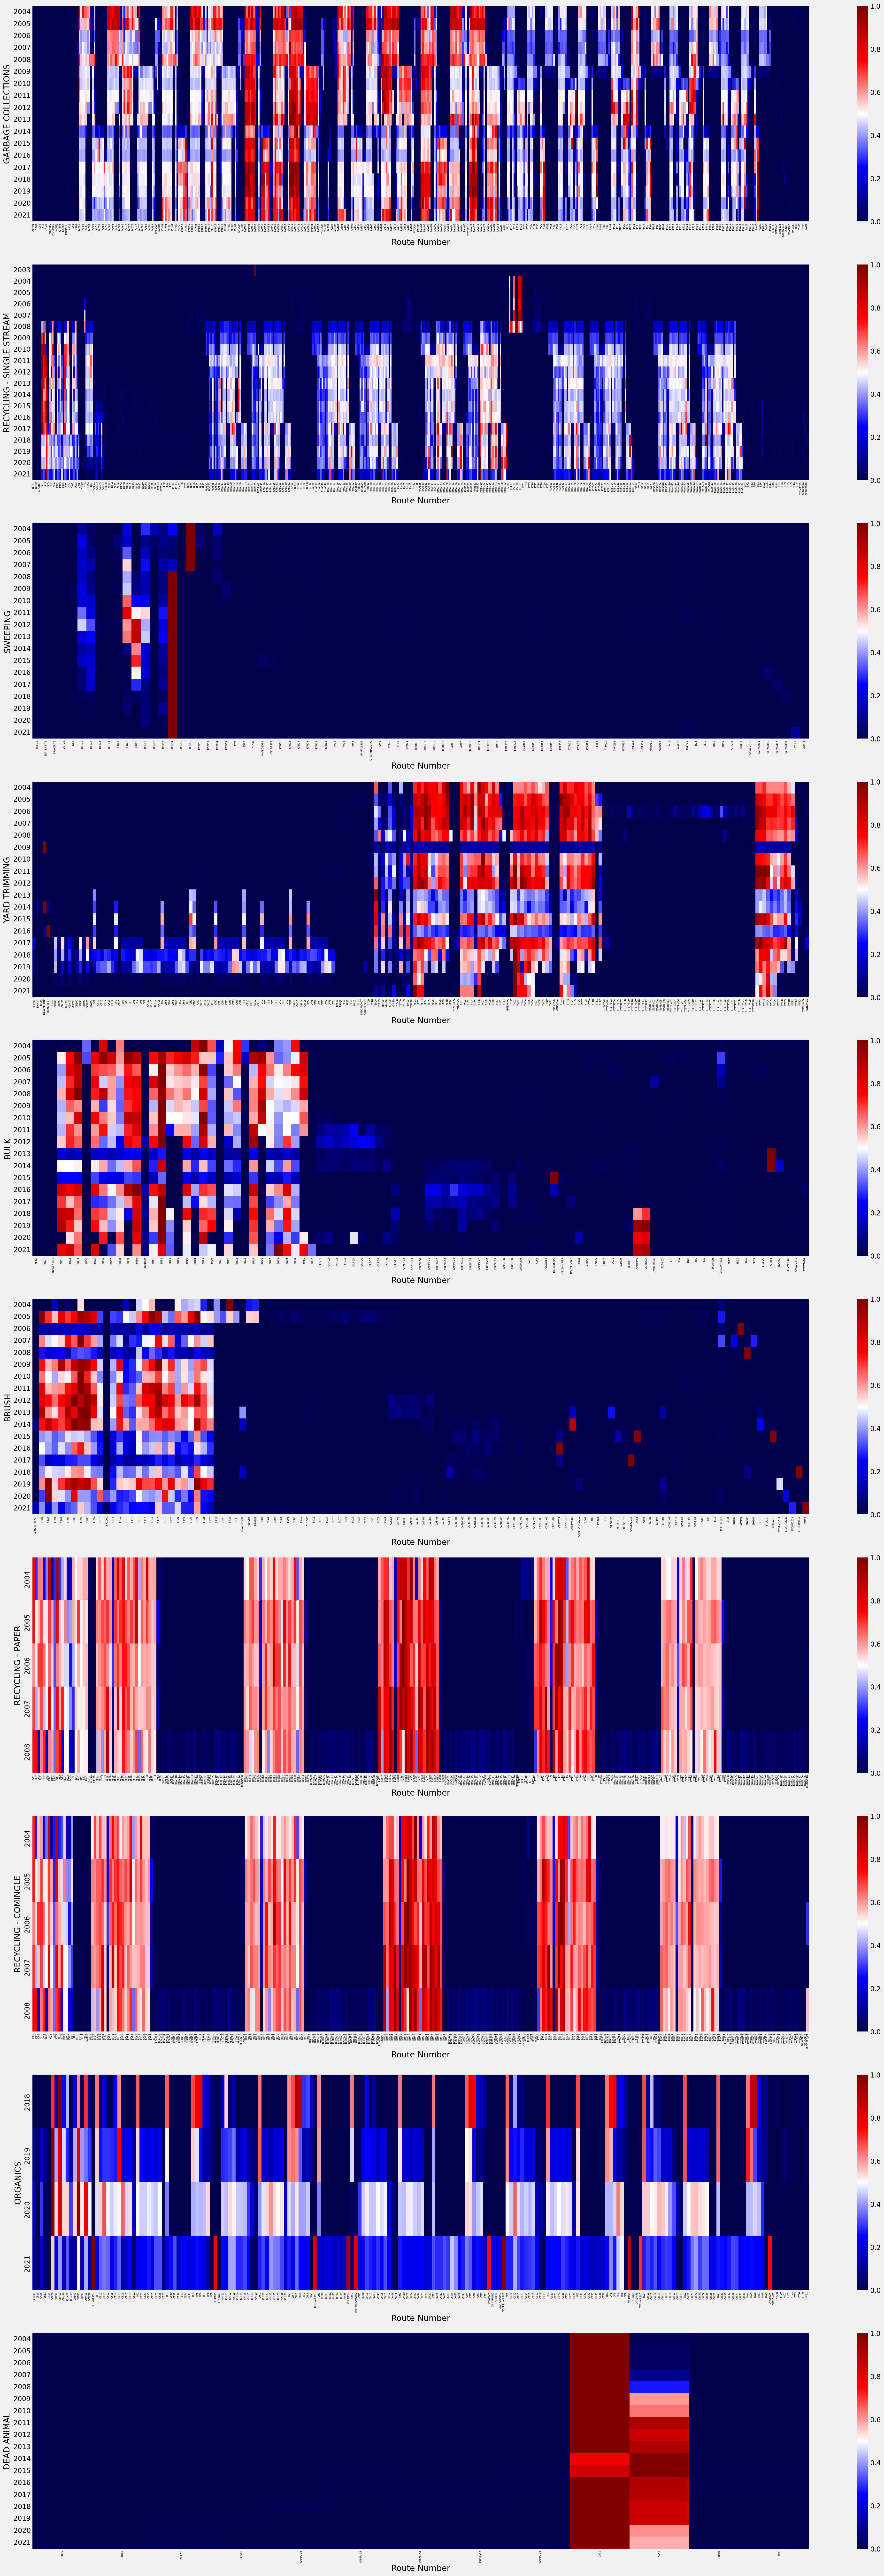

In [ ]:
plt.rcParams['figure.figsize'] = (32,9*10)
plt.rcParams['figure.dpi'] = 144

for i, key in enumerate(type_color_dict.keys()):
  filter_type_waste = daily_waste_austin[daily_waste_austin['Load Type'] == key]
  
  route_year_info = filter_type_waste.groupby(['Route Number', 'Year']).count()['Load Weight'].reset_index().pivot('Route Number', 'Year', 'Load Weight').fillna(0)
  route_year_info /= route_year_info.max()

  plt.subplot(len(type_color_dict.keys()), 1, 1+i)
  plt.xticks(rotation=90, fontsize=5);
  plt.yticks(rotation=90);
  sn.heatmap(route_year_info.T, cmap='seismic')
  plt.ylabel(key);

First, we tried to find a visualization that could let us evaluate a large part of the dataset. 

The main conclusion from this figure is that there are certain moments in time where there are abrupt changes in the routes. 

- 2008->2009 and 2013->2014 present significant changes in the routes for all types
- 2016->2017 reveals significant changes in the Single-Stream Recycling routes
- 2018 introduces Organic Waste to the mix


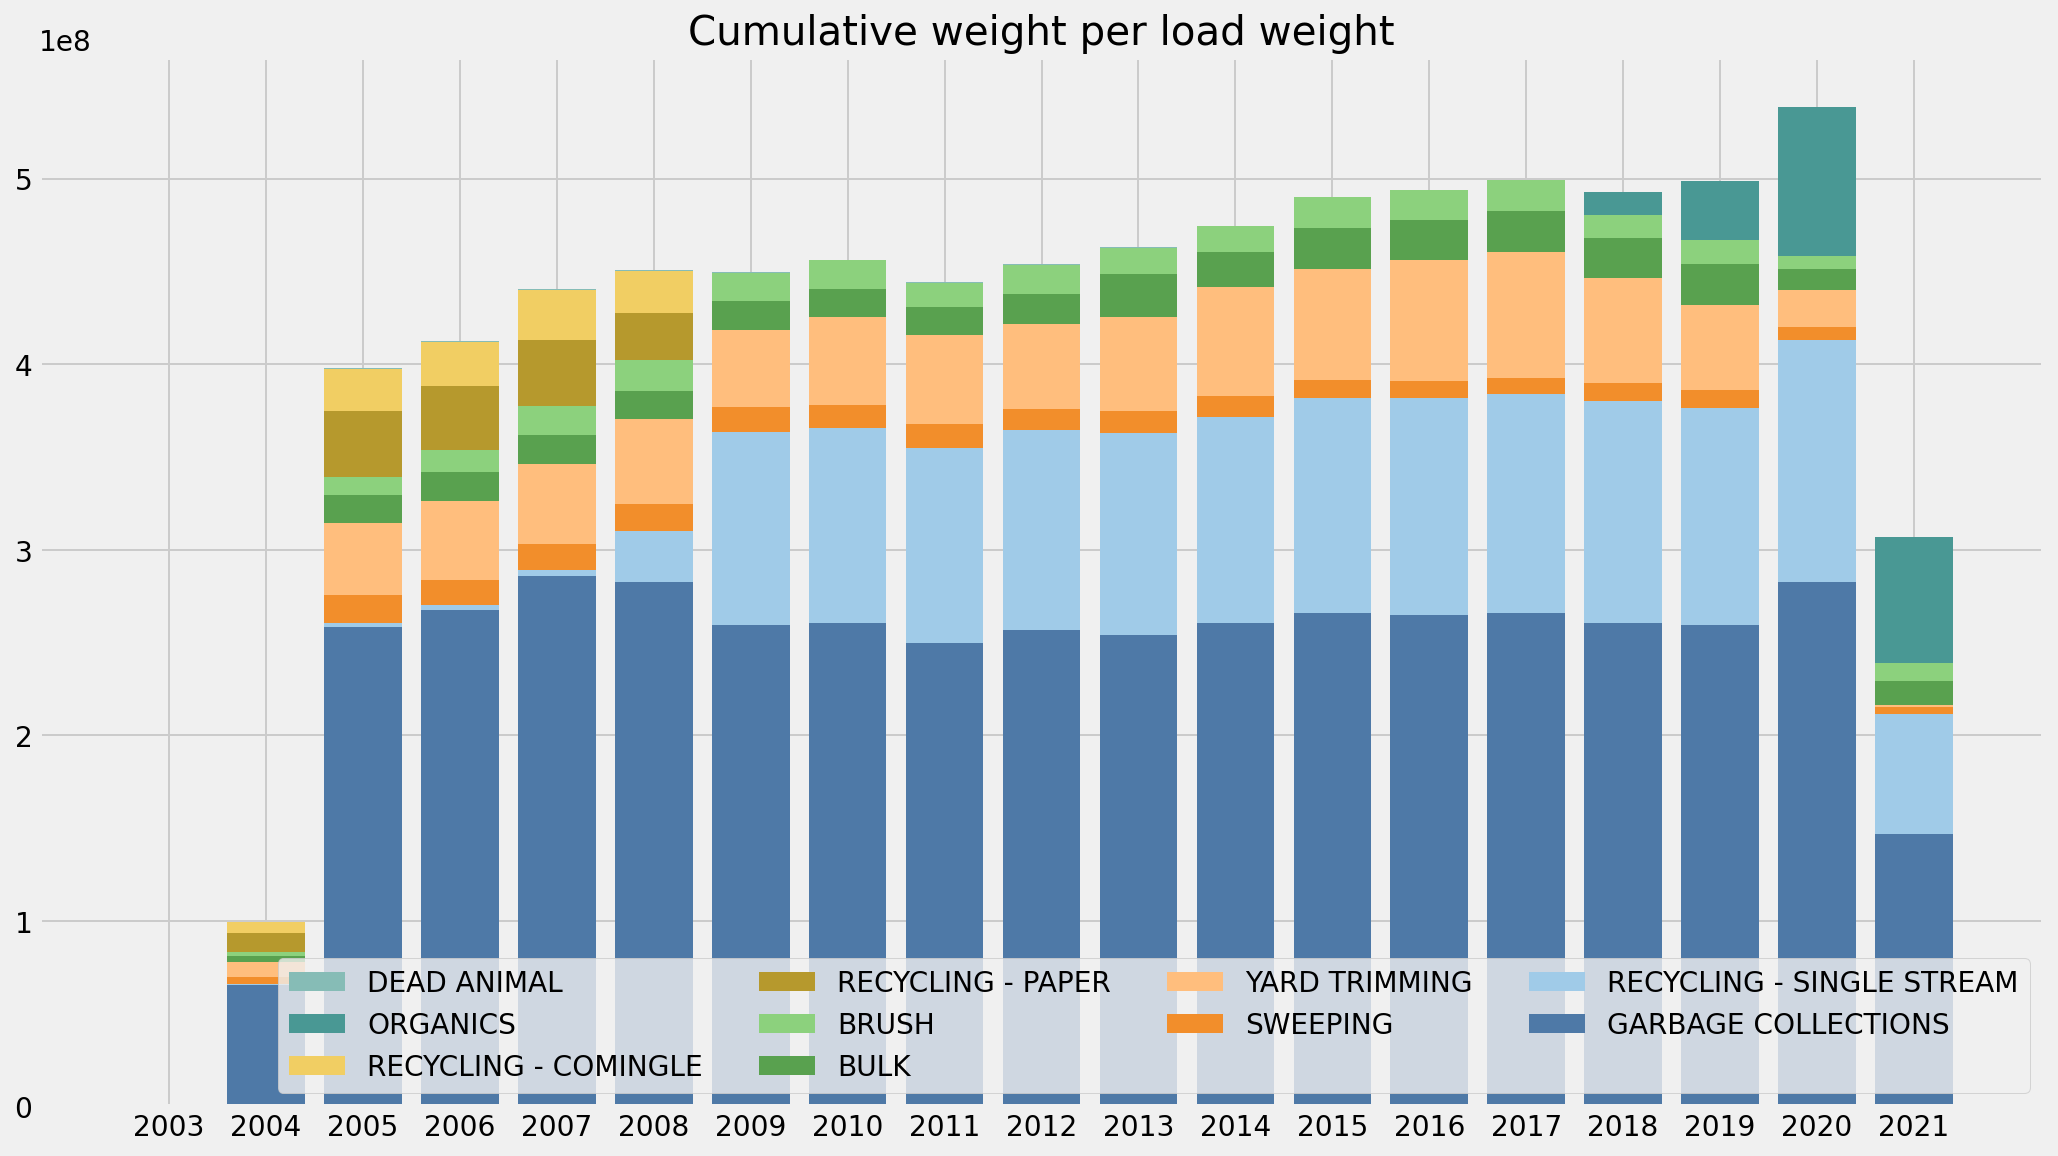

In [ ]:
plt.rcParams['figure.figsize'] = (16,9)
first_run = True
for year in [2003 + i for i in range(2022-2003)]:
  df = daily_waste_austin[daily_waste_austin.Year == year]

  value = df['Load Weight'].sum()
  for key in reversed(list(type_color_dict.keys())):
    if first_run:
      plt.bar(year, value, label=key, color=type_color_dict[key])
    else:
      plt.bar(year, value, color=type_color_dict[key])
    value -= df[df['Load Type'] == key]['Load Weight'].sum()

  first_run = False

plt.title('Cumulative weight per load weight')
plt.legend(ncol=4, loc='lower right')
plt.xticks([2003 + i for i in range(2022-2003)], [2003 + i for i in range(2022-2003)]);

This second plot allows us to understand how the types of waste recovered changed over time. Note the extinction of specific recycling types, which merged into the Single Stream Recycling, which we will further validate as a good choice when discussing efficiencies in the route.

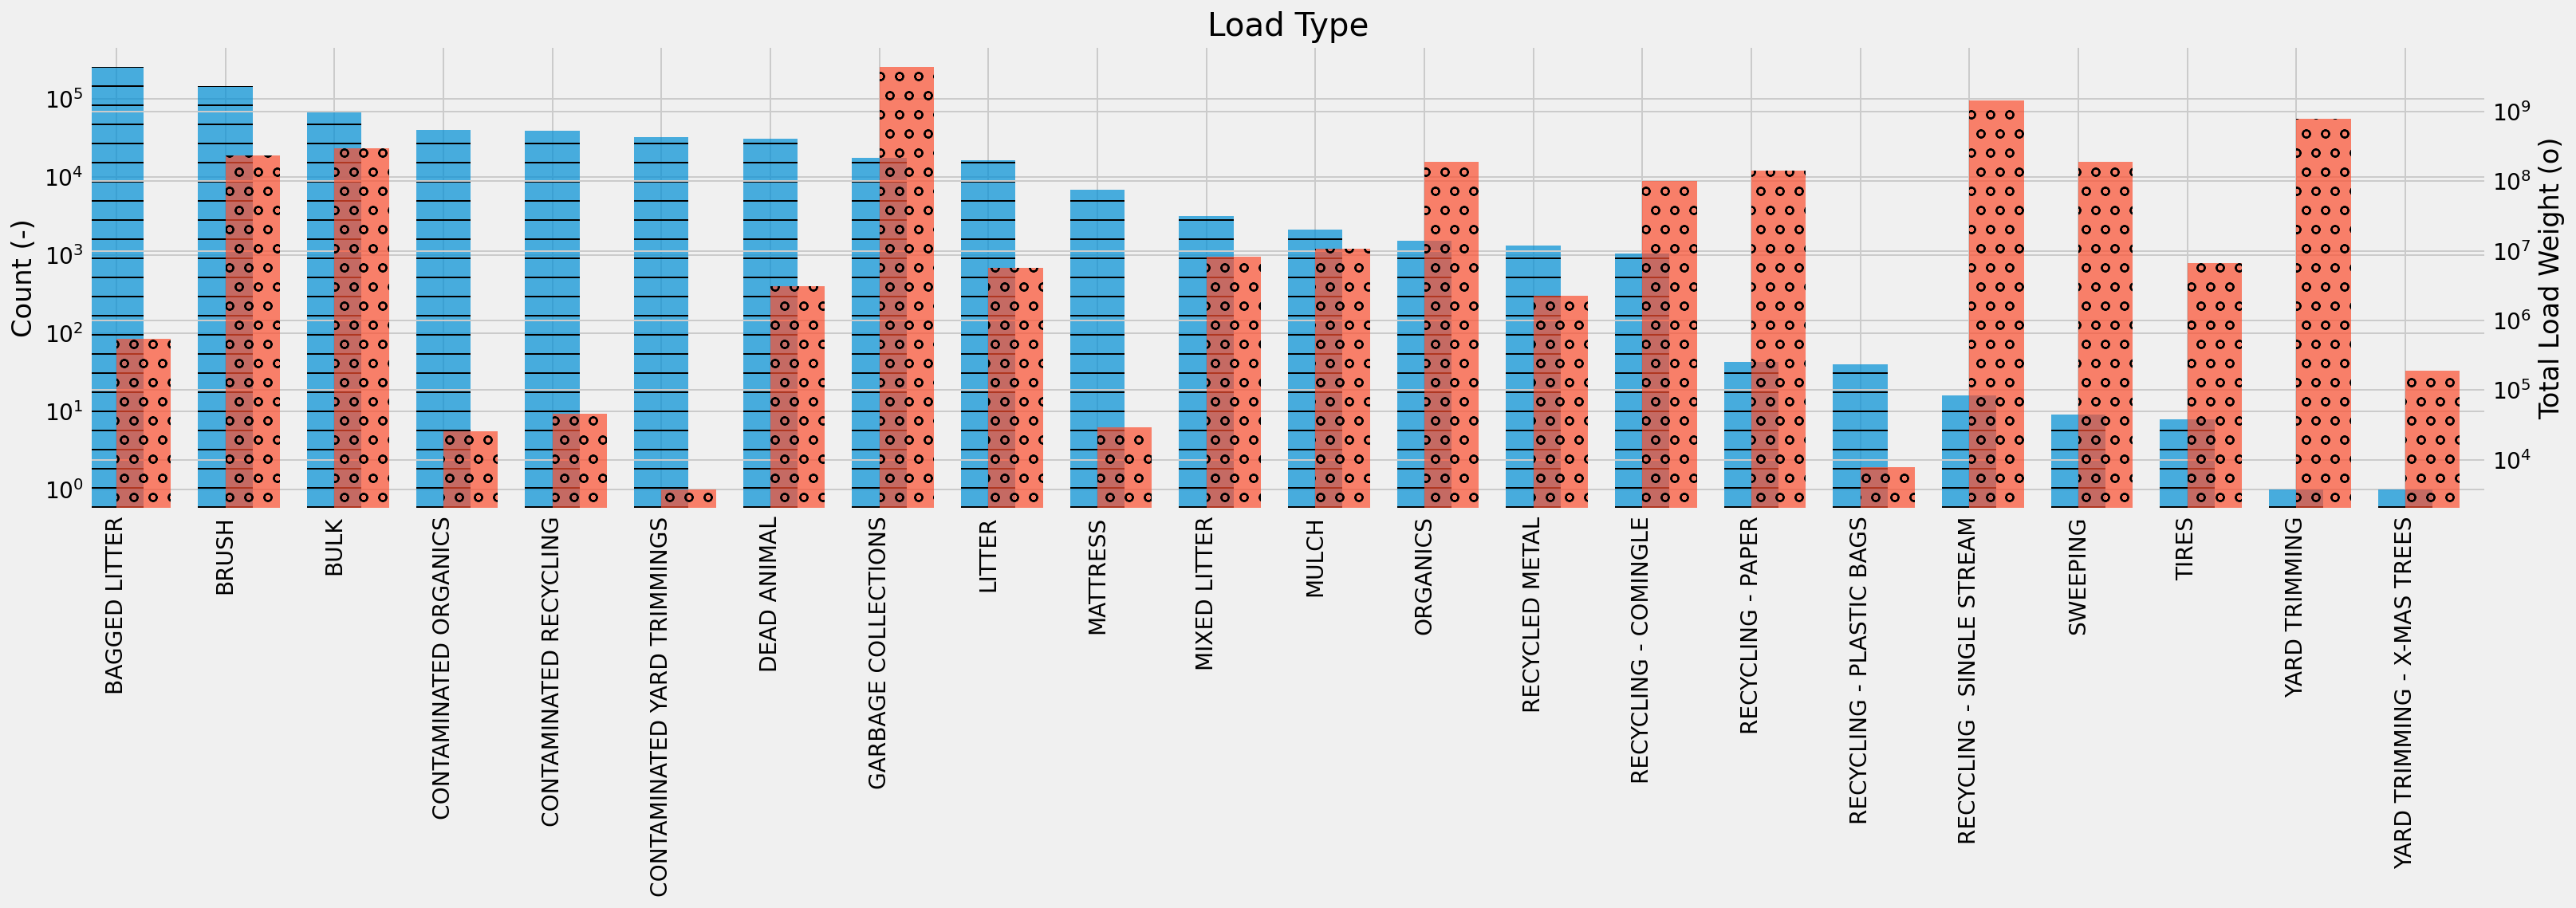

In [ ]:
def plot_count_vs_total_weight(df, varname, figsize=(24,5)):
  plt.rcParams['figure.figsize'] = figsize
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.set_yscale('log')
  ax2.set_yscale('log')

  plt.title(varname)
  ax1.set_ylabel('Count (-)')
  ax2.set_ylabel('Total Load Weight (o)')

  df[varname].value_counts().plot(kind='bar', ax=ax1, color='C0', alpha=0.7, hatch='-');
  df.groupby(varname).sum()['Load Weight'].plot(kind='bar', ax=ax2, color='C1', alpha=0.7, align='edge', hatch='o');

plot_count_vs_total_weight(daily_waste_austin, 'Load Type')

At last, we concluded that trucks are very likely limited by volume rather than the weight itself.

We analyzed which types of waste led to more trips and which kinds of waste led to more weight recovered.

Although we were unable to find a better proxy for waste volume than weight, we still firmly believe that this variable should be tracked to enhance the quality of future projects.

### 4 - Pre-Processing the data

First, we filter only route types with sufficient trips for our predictive task. Since we will make predictions every quarter, we think that routes that are likely to have a lot of quarters without any trip will not be able to be addressed by our models.

The Route Types used are shown in the output of the following cell.


In [ ]:
valid_route_types = daily_waste_austin['Route Type'].value_counts()[daily_waste_austin['Route Type'].value_counts() > 1500].index.to_list()
dwa_valid_routes = daily_waste_austin[daily_waste_austin['Route Type'].isin(valid_route_types)]
valid_route_types

['GARBAGE COLLECTION',
 'RECYCLING - SINGLE STREAM',
 'YARD TRIMMINGS',
 'RECYCLING',
 'BULK',
 'BRUSH',
 'YARD TRIMMINGS-ORGANICS',
 'SWEEPER DUMPSITES',
 'DEAD ANIMAL',
 'INHOUSE - RECYCLING',
 'STORM',
 'KAB',
 'HAULING',
 'LITTER CONTROL']

Then, we'll create valuable fields to be inducted into the model.

The most important metric we created is the *Route Type Capacity*, an important variable to gauge the occupancy level that a specific truck in a particular route is carrying when making its' final deposit.

For each route type, we considered the *Route Type Capacity* as the 99% percentile in terms of weight. This is a proxy for truck capacity and should be considered an estimation since we could not find documentation on the actual truck capacity for each waste type.

The estimated *Capacity %* for each trip equals the load_weight of a trip divided by the *Route Type Capacity*.

In [ ]:
df = dwa_valid_routes.groupby(['Route Number', 'Route Type', 'Year', 'Quarter']).sum()['Load Weight'].reset_index()
df['Trips'] = dwa_valid_routes.groupby(['Route Number', 'Route Type', 'Year', 'Quarter']).count()['Load Weight'].to_list()
df['Weight STDev'] = dwa_valid_routes.groupby(['Route Number', 'Route Type', 'Year', 'Quarter']).std()['Load Weight'].to_list()
df = df[df.Trips != 0].copy()
df['Weight per Trip'] = df['Load Weight'] / df['Trips']
df = df.merge(df.rename(columns={'Weight per Trip':'Route Type Capacity'}).groupby('Route Type')['Route Type Capacity'].quantile(0.99), on='Route Type')
df['Capacity %'] = df['Weight per Trip'] / df['Route Type Capacity'] * 100
df = df[df['Capacity %'] < 120]
df = df.sort_values(['Year', 'Quarter'])
df.head(8)

,Route Number,Route Type,Year,Quarter,Load Weight,Trips,Weight STDev,Weight per Trip,Route Type Capacity,Capacity %
10145,RFBS35,RECYCLING - SINGLE STREAM,2003,1,20170.0,1,NaN,20170.0,17179.788571,117.405403
20368,PAF60,GARBAGE COLLECTION,2004,3,26400.0,2,6477.098116,13200.0,26140.461538,50.496431
22629,PAH60,GARBAGE COLLECTION,2004,3,29560.0,2,8202.438662,14780.0,26140.461538,56.540700
29770,PAW60,GARBAGE COLLECTION,2004,3,38560.0,2,3535.533906,19280.0,26140.461538,73.755392
29839,PAW61,GARBAGE COLLECTION,2004,3,40580.0,2,5161.879503,20290.0,26140.461538,77.619134
29908,PAW62,GARBAGE COLLECTION,2004,3,33600.0,2,16716.004307,16800.0,26140.461538,64.268184
33051,PH30,GARBAGE COLLECTION,2004,3,26040.0,1,NaN,26040.0,26140.461538,99.615686
33120,PH31,GARBAGE COLLECTION,2004,3,23460.0,1,NaN,23460.0,26140.461538,89.745929


#### Distribution of Truck Capacity Occupied

This is perhaps the most important data point in our work.

On average, the trucks reach their final destination with **39% of available container space**.

This strengthens our view that we need robust optimization of truck routes.

On average the trucks are clocking out with 39.3% of free space


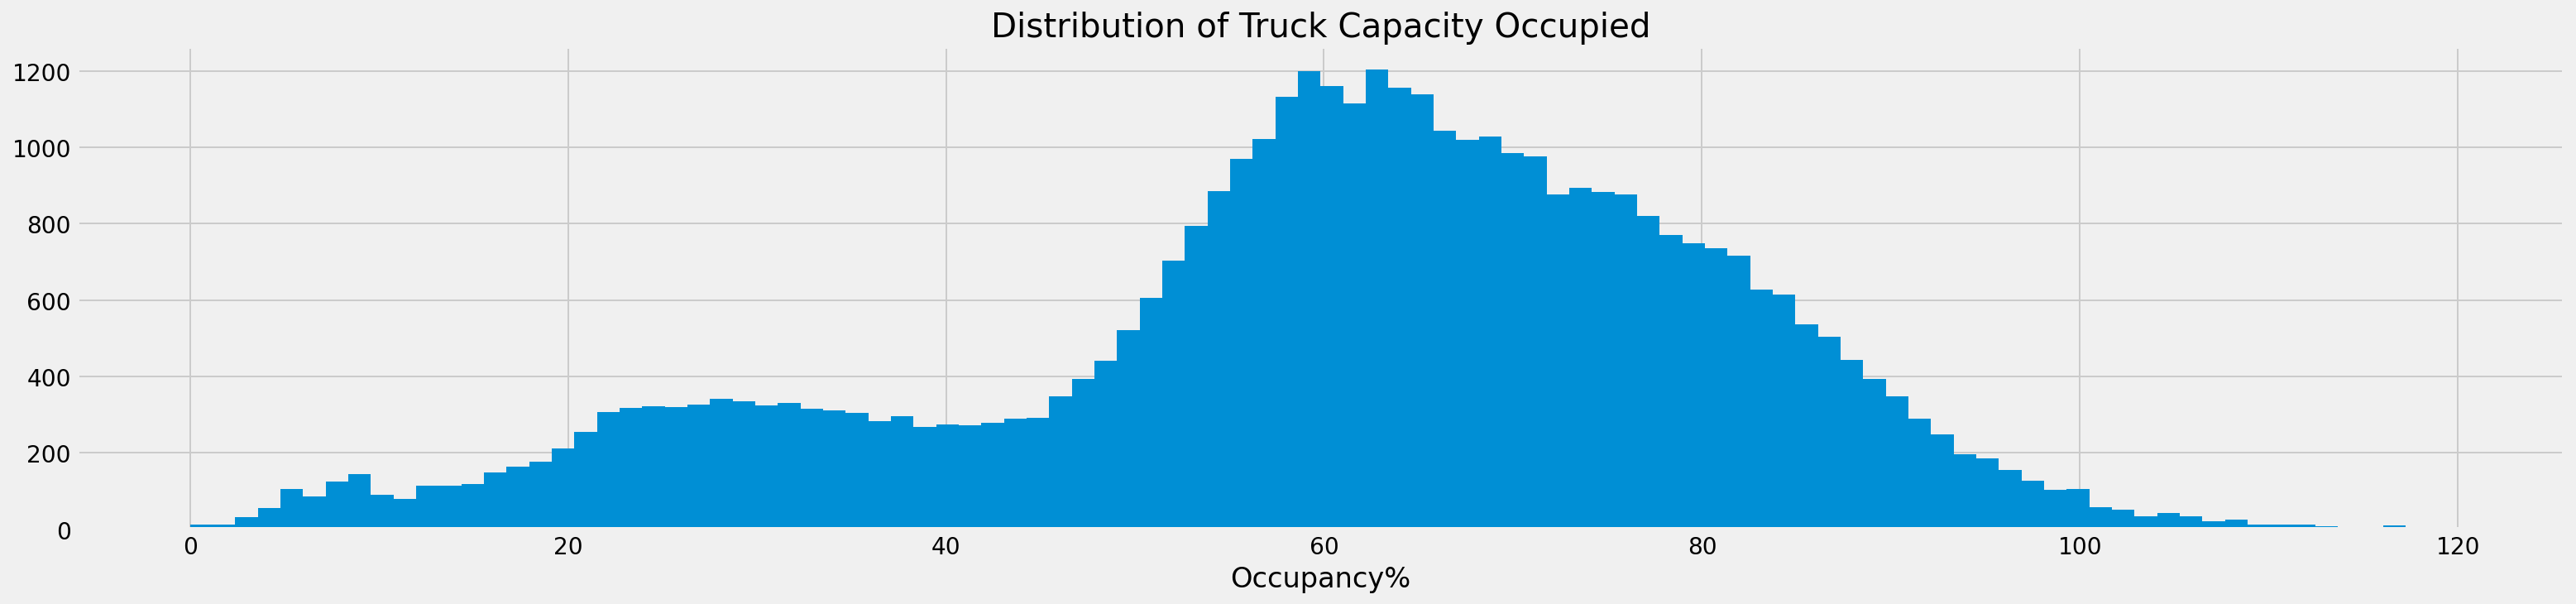

In [ ]:
plt.title('Distribution of Truck Capacity Occupied')
plt.xlabel('Occupancy%')
df['Capacity %'].hist(bins=100);
print("On average the trucks are clocking out with {}% of free space".format(round((100 - df['Capacity %']).mean(),1)))

#### Processing data for the predictive problem

Here, we perform the following steps:
- Create a list with all the time series, created by the route

- For each time series, perform a segmentation step, which divides each time series into multiple segments composed of the information we want to predict (Total Weight in a quarter, Capacity %, ...). It also contains various features that we consider important to make such prediction (Total Weight in each of the last four quarters, Number of trips in the previous four quarters, ...)

- We encode Route Type in a Sequential Encoder because our algorithms require only numerical data.

In [ ]:
series = []
for rn in df['Route Number'].unique():
  series.append(df[df['Route Number'] == rn])
series[0].head(5)
display(len(series))

1408

In [ ]:
modeling_set = []
for serie in series:
  route_number, route_type, prev_date = None, None, None
  year, quarter, load_weight, trips, weight_per_trip, capacity = [], [], [], [], [], []
  for i, row in serie.iterrows():
    if prev_date == None:
      route_number, route_type = row['Route Number'], row['Route Type']
      prev_date = row.Year + row.Quarter/4
      year.append(row['Year'])
      quarter.append(row['Quarter'])
      load_weight.append(row['Load Weight'])
      trips.append(row['Trips'])
      weight_per_trip.append(row['Weight per Trip'])
      capacity.append(row['Capacity %'])
      continue
    elif prev_date == row.Year + (row.Quarter - 1)/4:
      year.append(row['Year'])
      quarter.append(row['Quarter'])
      load_weight.append(row['Load Weight'])
      trips.append(row['Trips'])
      weight_per_trip.append(row['Weight per Trip'])
      capacity.append(row['Capacity %'])
      prev_date = row.Year + row.Quarter/4
    else:
      dummy_year, dummy_quarter = year[-1], quarter[-1]
      if dummy_quarter == 4:
        dummy_year += 1
        dummy_quarter = 0
      else:
        dummy_quarter += 1
      while row.Year + row.Quarter/4 >= dummy_year + dummy_quarter/4:
        year.append(dummy_year)
        quarter.append(dummy_quarter)
        load_weight.append(0)
        trips.append(0)
        weight_per_trip.append(0)
        capacity.append(0)
        if dummy_quarter == 4:
          dummy_year += 1
          dummy_quarter = 0
        else:
          dummy_quarter += 1
      prev_date = row.Year + row.Quarter/4
    if len(year) > 5:
      modeling_set.append([route_number, route_type,
                          year[-1], quarter[-1], load_weight[-1], trips[-1], weight_per_trip[-1], capacity[-1],
                          load_weight[-5], load_weight[-4], load_weight[-3], load_weight[-2], 
                          trips[-5], trips[-4], trips[-3], trips[-2], 
                          weight_per_trip[-5], weight_per_trip[-4], weight_per_trip[-3], weight_per_trip[-2], 
                          capacity[-5], capacity[-4], capacity[-3], capacity[-2]])

In [ ]:
modeling_df = pd.DataFrame(modeling_set, 
             columns=['route_number', 'route_type',
                      'year', 'quarter', 'load_weight', 'trips', 'weight_per_trip', 'capacity',
                      'load_weight_-4q', 'load_weight_-3q', 'load_weight_-2q', 'load_weight_-1q',
                      'trips_-4q', 'trips_-3q', 'trips_-2q', 'trips_-1q',
                      'weight_per_trip_-4q', 'weight_per_trip_-3q', 'weight_per_trip_-2q', 'weight_per_trip_-1q',
                      'capacity_-4q', 'capacity_-3q', 'capacity_-2q', 'capacity_-1q'])
modeling_df = modeling_df[(modeling_df.trips != 0) & (modeling_df.load_weight != 0)]
display(modeling_df.head(5))
display(modeling_df.shape)

,route_number,route_type,year,quarter,load_weight,trips,weight_per_trip,capacity,load_weight_-4q,load_weight_-3q,...,trips_-2q,trips_-1q,weight_per_trip_-4q,weight_per_trip_-3q,weight_per_trip_-2q,weight_per_trip_-1q,capacity_-4q,capacity_-3q,capacity_-2q,capacity_-1q
1,RFBS35,RECYCLING - SINGLE STREAM,2008,4,77740.0,10,7774.000000,45.250848,0.0,0.0,...,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,RFBS35,RECYCLING - SINGLE STREAM,2009,1,154080.0,14,11005.714286,64.061989,0.0,0.0,...,0,10,0.0,0.000000,0.000000,7774.000000,0.000000,0.000000,0.000000,45.250848
3,RFBS35,RECYCLING - SINGLE STREAM,2009,2,122740.0,12,10228.333333,59.537015,0.0,0.0,...,10,14,0.0,0.000000,7774.000000,11005.714286,0.000000,0.000000,45.250848,64.061989
4,RFBS35,RECYCLING - SINGLE STREAM,2009,3,135620.0,14,9687.142857,56.386857,0.0,77740.0,...,14,12,0.0,7774.000000,11005.714286,10228.333333,0.000000,45.250848,64.061989,59.537015
5,RFBS35,RECYCLING - SINGLE STREAM,2009,4,120220.0,11,10929.090909,63.615980,77740.0,154080.0,...,12,14,7774.0,11005.714286,10228.333333,9687.142857,45.250848,64.061989,59.537015,56.386857


(32183, 24)

In [ ]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
modeling_df['enc_route_type'] = enc.fit_transform(modeling_df['route_type'])

### 5 - Models

**GOAL:** 

We intend to create regression models to predict weight levels for any given quarter in a specific route for a future goal of having dynamic route management. 

We'll be using the data before 2016 and the remainder as the test set for our training set. We did this to ensure the temporal continuity of our predictions, making our results more reliable. 

However, some waste types are not available before 2016 (e.g., Organics), which is damaging the performance of our algorithms significantly. While we had no time to address this issue, we would ideally isolate that specific route type (organics) and treat it differently.

1st model will attempt to gauge the load weight per quarter, given the information of four previous quarters. This model will guide decision-makers through the expected amount of waste produced in a quarter.

2nd model will strive to predict the Capacity % (aka Occupancy) for a given quarter for each truck route. This model will allow operators to understand which routes are optimized (high values of Capacity %) or which routes are not, leading to negative social impacts.

We visualize which variables had the most impact on the prediction for each model.


-------
Evaluation Metrics:  
Why are we using the **median** as an evaluation error?
In some instances, we have a low waste collection, and our models do not have the features to anticipate this. Therefore, our models fail by up to 700% in those circumstances, skewing our metrics towards a worse result.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error

In [ ]:
# Train-test split
train_set = modeling_df[modeling_df.year < 2016].copy()
test_set = modeling_df[modeling_df.year >= 2016].copy()

print("Training Set Size:{}".format(len(train_set)))
print("Testing Set Size:{}".format(len(test_set)))

Training Set Size:19141
Testing Set Size:13042


#### Model 1 - Gradient boosting to predict total weight in a quarter (Weight per Quarter)

20050.13125212786 12.1%


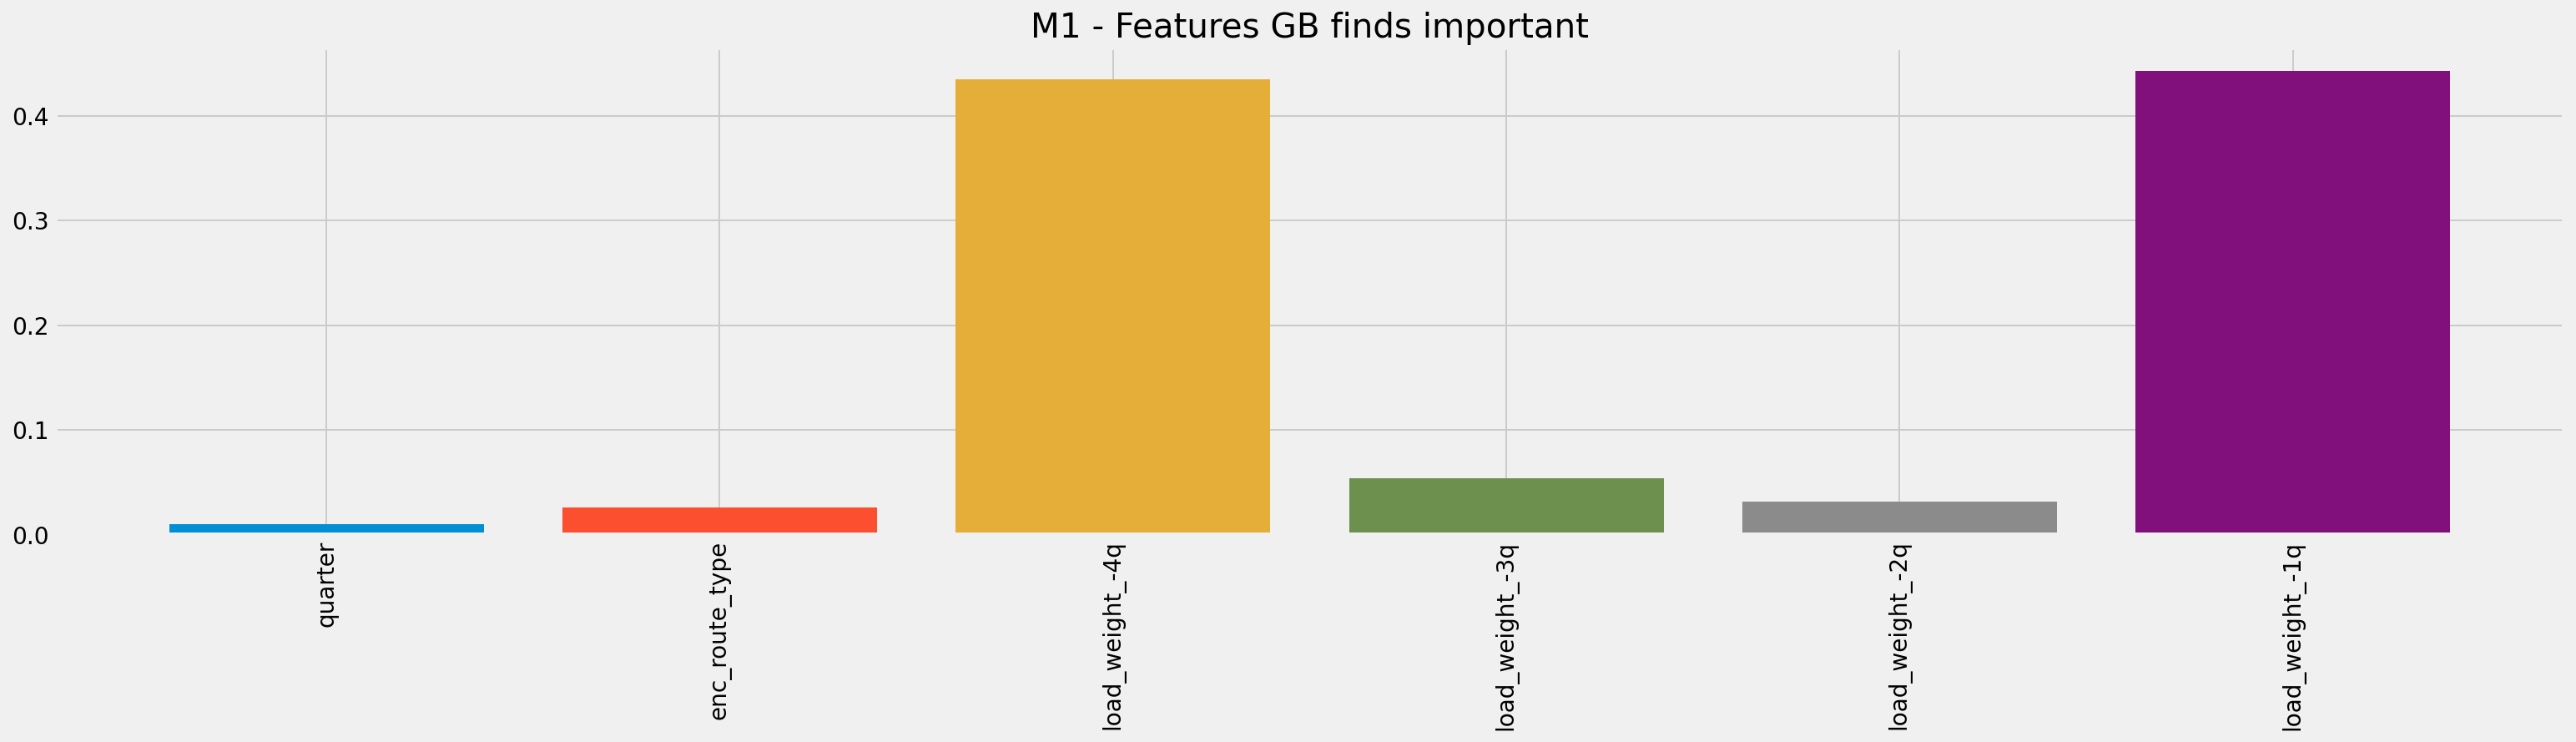

In [ ]:
features_m2 = ['quarter', 'enc_route_type', 'load_weight_-4q', 'load_weight_-3q', 'load_weight_-2q', 'load_weight_-1q']
target_m2 = 'load_weight'

m2 = GradientBoostingRegressor(n_estimators=1000)
m2.fit(train_set[features_m2], train_set[target_m2]);

test_set['m2_output'] = m2.predict(test_set[features_m2])
median_ae = median_absolute_error(test_set[target_m2], test_set['m2_output'])
median_target = modeling_df[target_m2].median()
print(median_ae, f'{round(median_ae/median_target * 100, 1)}%')

for feature, importance in zip(features_m2, m2.feature_importances_):
  plt.bar(feature, importance)
plt.title('M1 - Features GB finds important')
plt.xticks(rotation=90);

As one can conclude, there's a significant association between the latest quarter and the same quarter from the previous year.


#### Model 2 - GB predicts truck occupancy in a quarter

5.215942464611523 8.1%


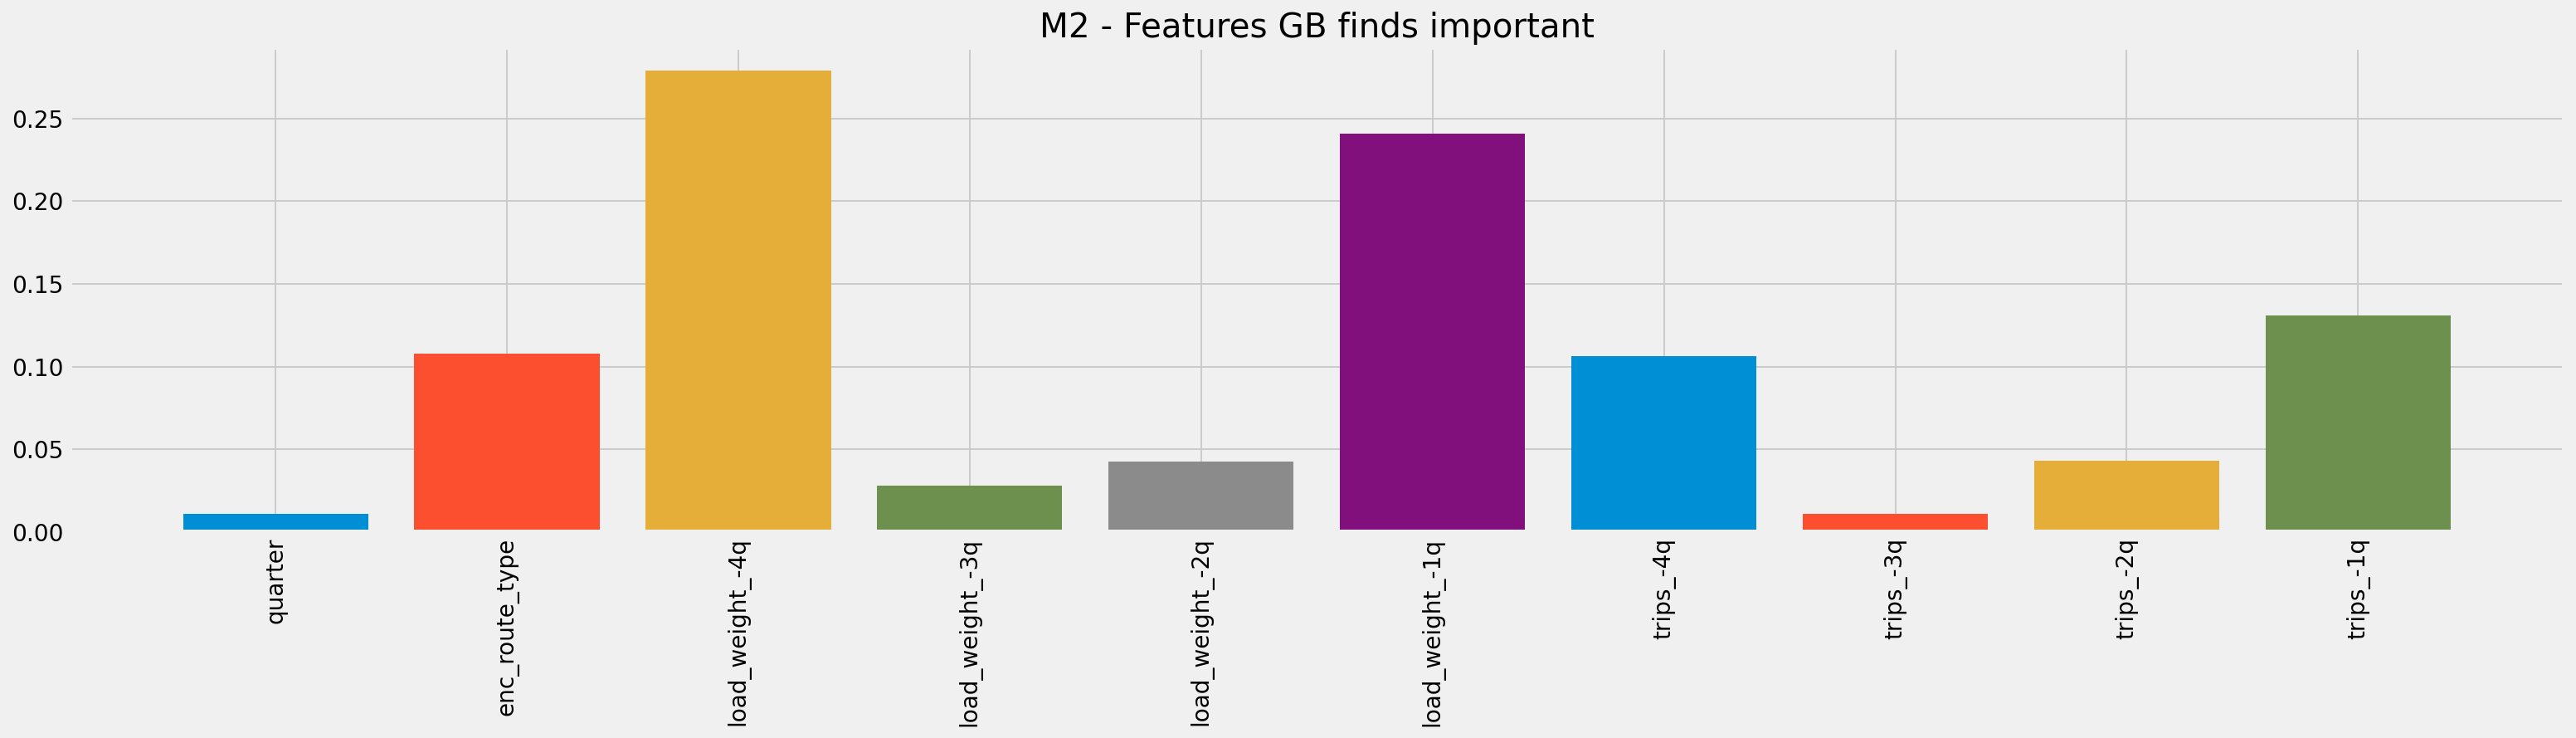

In [ ]:
features_m5 = ['quarter', 'enc_route_type', 'load_weight_-4q', 'load_weight_-3q', 'load_weight_-2q', 'load_weight_-1q', 'trips_-4q', 'trips_-3q', 'trips_-2q', 'trips_-1q']
target_m5 = 'capacity'

m5 = GradientBoostingRegressor(n_estimators=1000)
m5.fit(train_set[features_m5], train_set[target_m5]);

test_set['m5_output'] = m5.predict(test_set[features_m5])
median_ae = median_absolute_error(test_set[target_m5], test_set['m5_output'])
median_target = modeling_df[target_m5].median()
print(median_ae, f'{round(median_ae/median_target * 100, 1)}%')
for feature, importance in zip(features_m5, m5.feature_importances_):
  plt.bar(feature, importance)
plt.title('M2 - Features GB finds important')
plt.xticks(rotation=90);

In opposition to the Weight per Quarter prediction, the Capacity % model can handle the route type better. This feature has a substantially higher impact when compared to the other features. 

### 6 - Future Work

  - It would result in additional value to have data regarding Waste pickup routes that the trucks follow.

  - We considered Year quarters as the only acceptable time interval for model training, as the frequency/load weight wouldn't be statistically significant for an accurate model prediction. We would solve this problem by :  
      - Grouping some *'Route Types'* categories together. Some types of Waste require handling their data with care, which we did not have the resources to do in this challenge.
      - Having additional data points to render another time interval feasible for training. Data for Waste volume can also be beneficial to optimize truck routes.

## 🖼️ Visualisations
The following visualizations complement some of the insights on our notebook.

In [ ]:
route_type_color_dict = {
    'RECYCLING - SINGLE STREAM':'#4363d8', 
    'GARBAGE COLLECTION':'#e6194B', 
    'RECYCLING':'#469990',
    'BRUSH':'#3cb44b', 
    'YARD TRIMMINGS':'#808000', 
    'BULK':'#f58231', 
    'DEAD ANIMAL':'#9A6324',
    'SWEEPER DUMPSITES':'#911eb4', 
    'INHOUSE - RECYCLING':'#000075', 
    'KAB':'#f032e6',
    'LITTER CONTROL':'#000000', 
    'HAULING':'#fabed4', 
    'YARD TRIMMINGS-ORGANICS':'#808000'
}

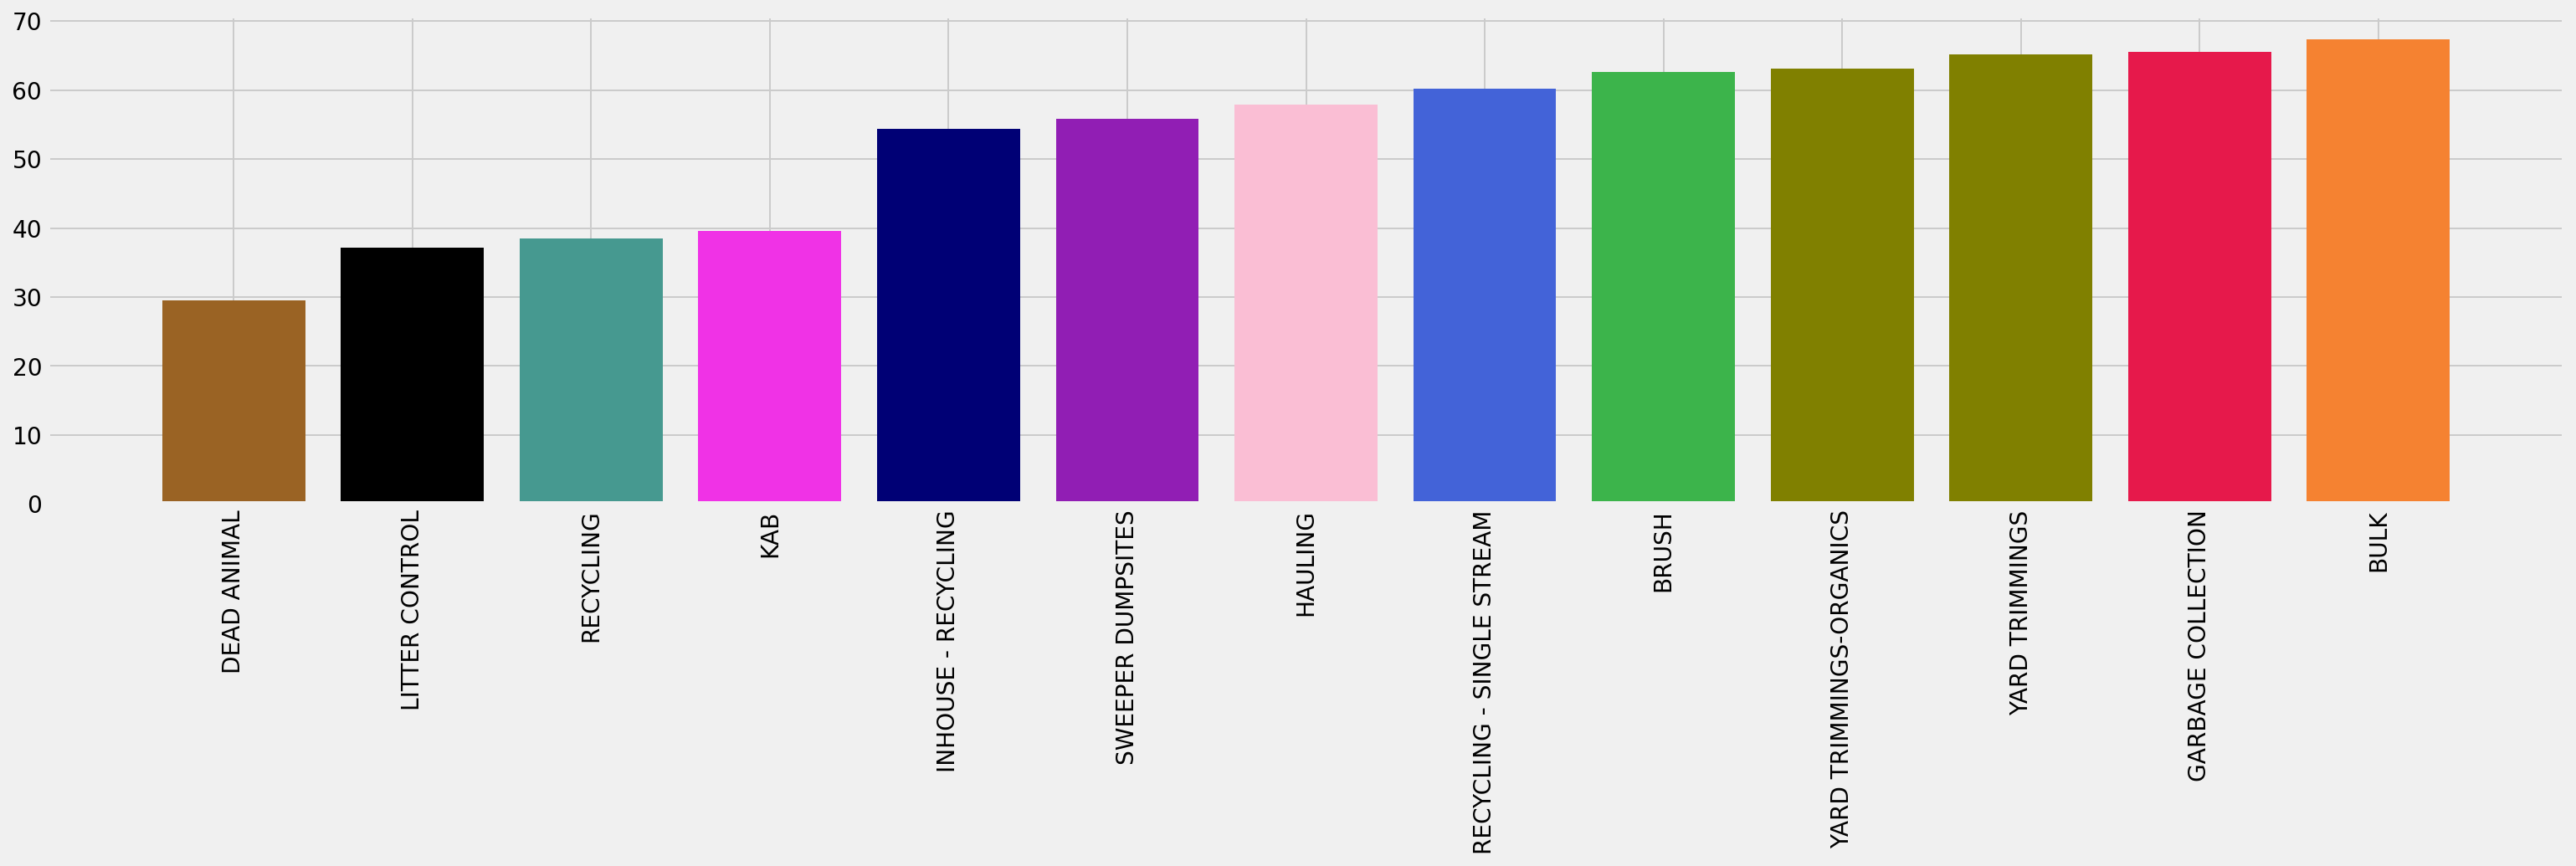

In [ ]:
for i, row in modeling_df.groupby('route_type')[['capacity']].mean().sort_values('capacity').reset_index().iterrows():
  plt.bar(row.route_type, row.capacity, color=route_type_color_dict[row.route_type])
plt.xticks(rotation=90);

Note the higher efficiency of Single Stream Recycling compared to other types of recycling. Obviously, by merging different types of Waste routes, we can have more efficient routes. Therefore, it is important to study how we can combine routes to decrease their environmental impact.

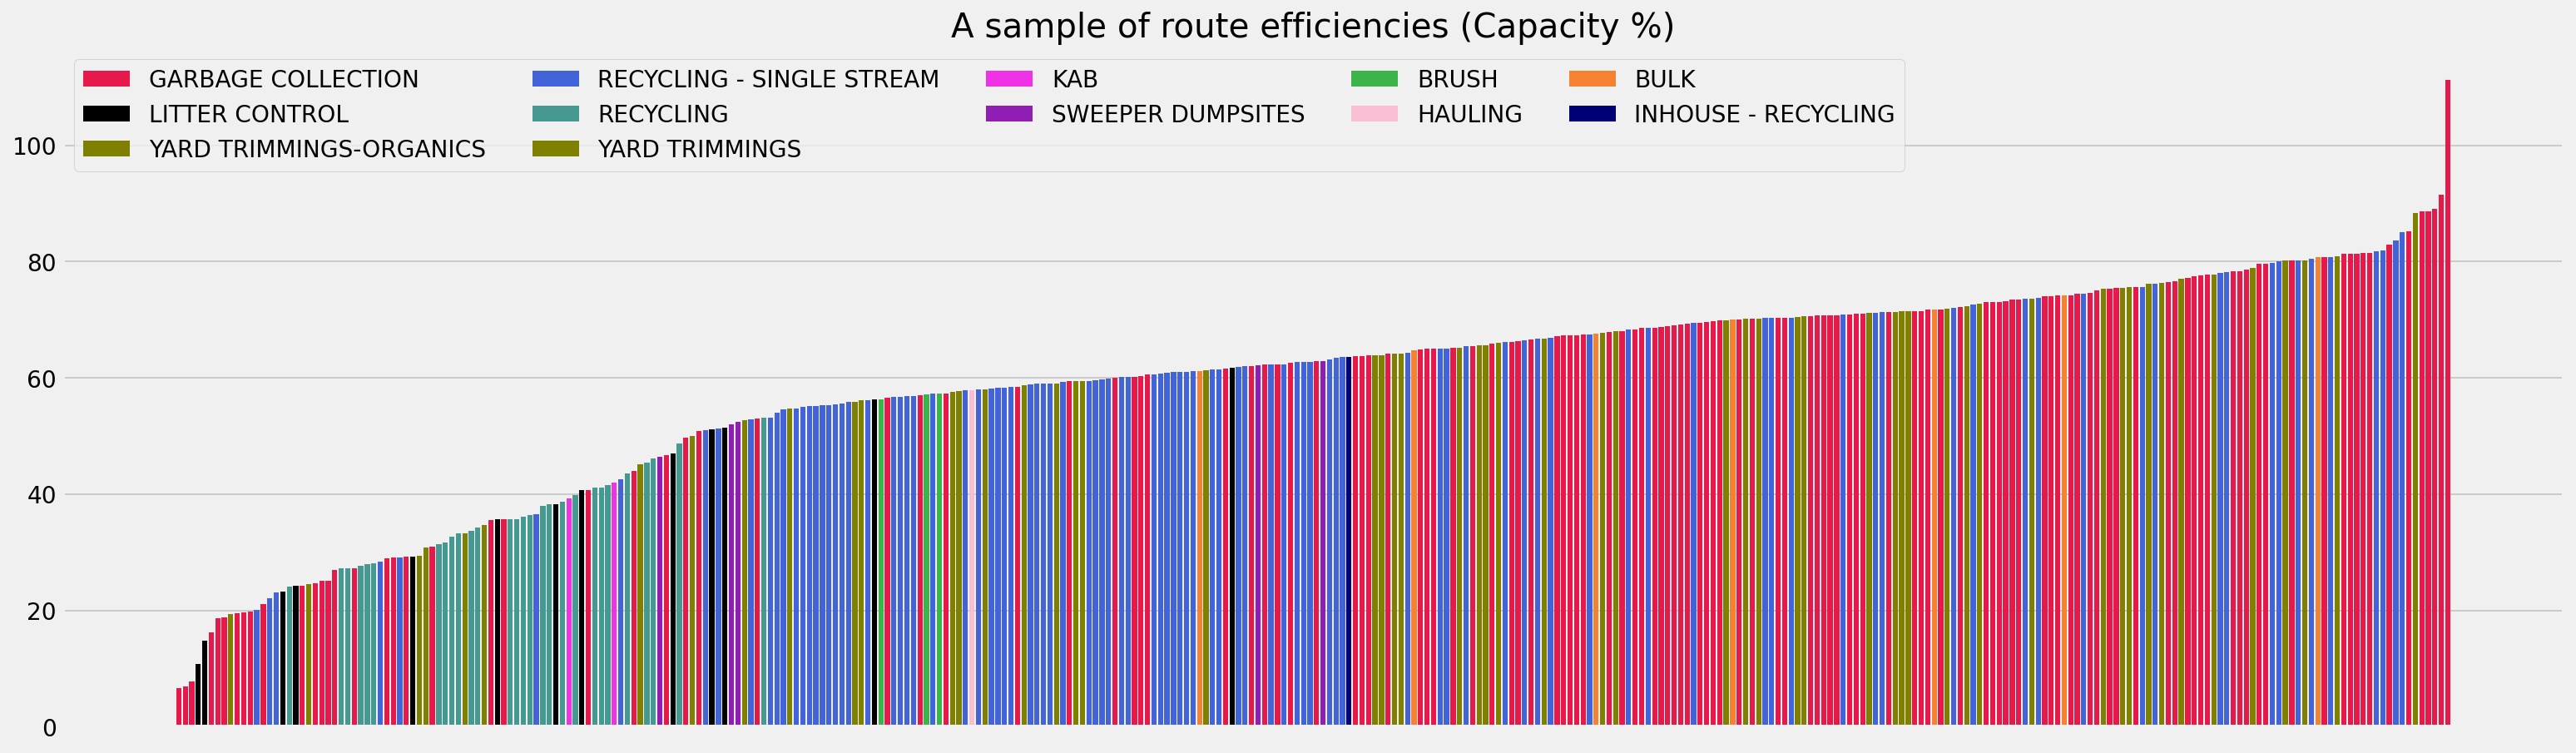

In [ ]:
plt.rcParams['figure.figsize'] = (24,7)
for i, row in modeling_df.groupby(['route_number', 'route_type'])[['route_type', 'capacity']].mean().sample(350).sort_values('capacity').reset_index().iterrows():
  plt.bar(row.route_number, row.capacity, color=route_type_color_dict[row.route_type], label=row.route_type)
plt.xticks([]);
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title('A sample of route efficiencies (Capacity %)')
plt.legend(by_label.values(), by_label.keys(), loc='upper left', ncol=5);

As a Route Operator, we would look at the least efficient routes for each type and understand why they are underperforming the remaining routes of their type. Then, we are left with two choices: reducing the number of trips (if it does not cause inconvenience to the clients or public health safety concerns) or redesigning the route.

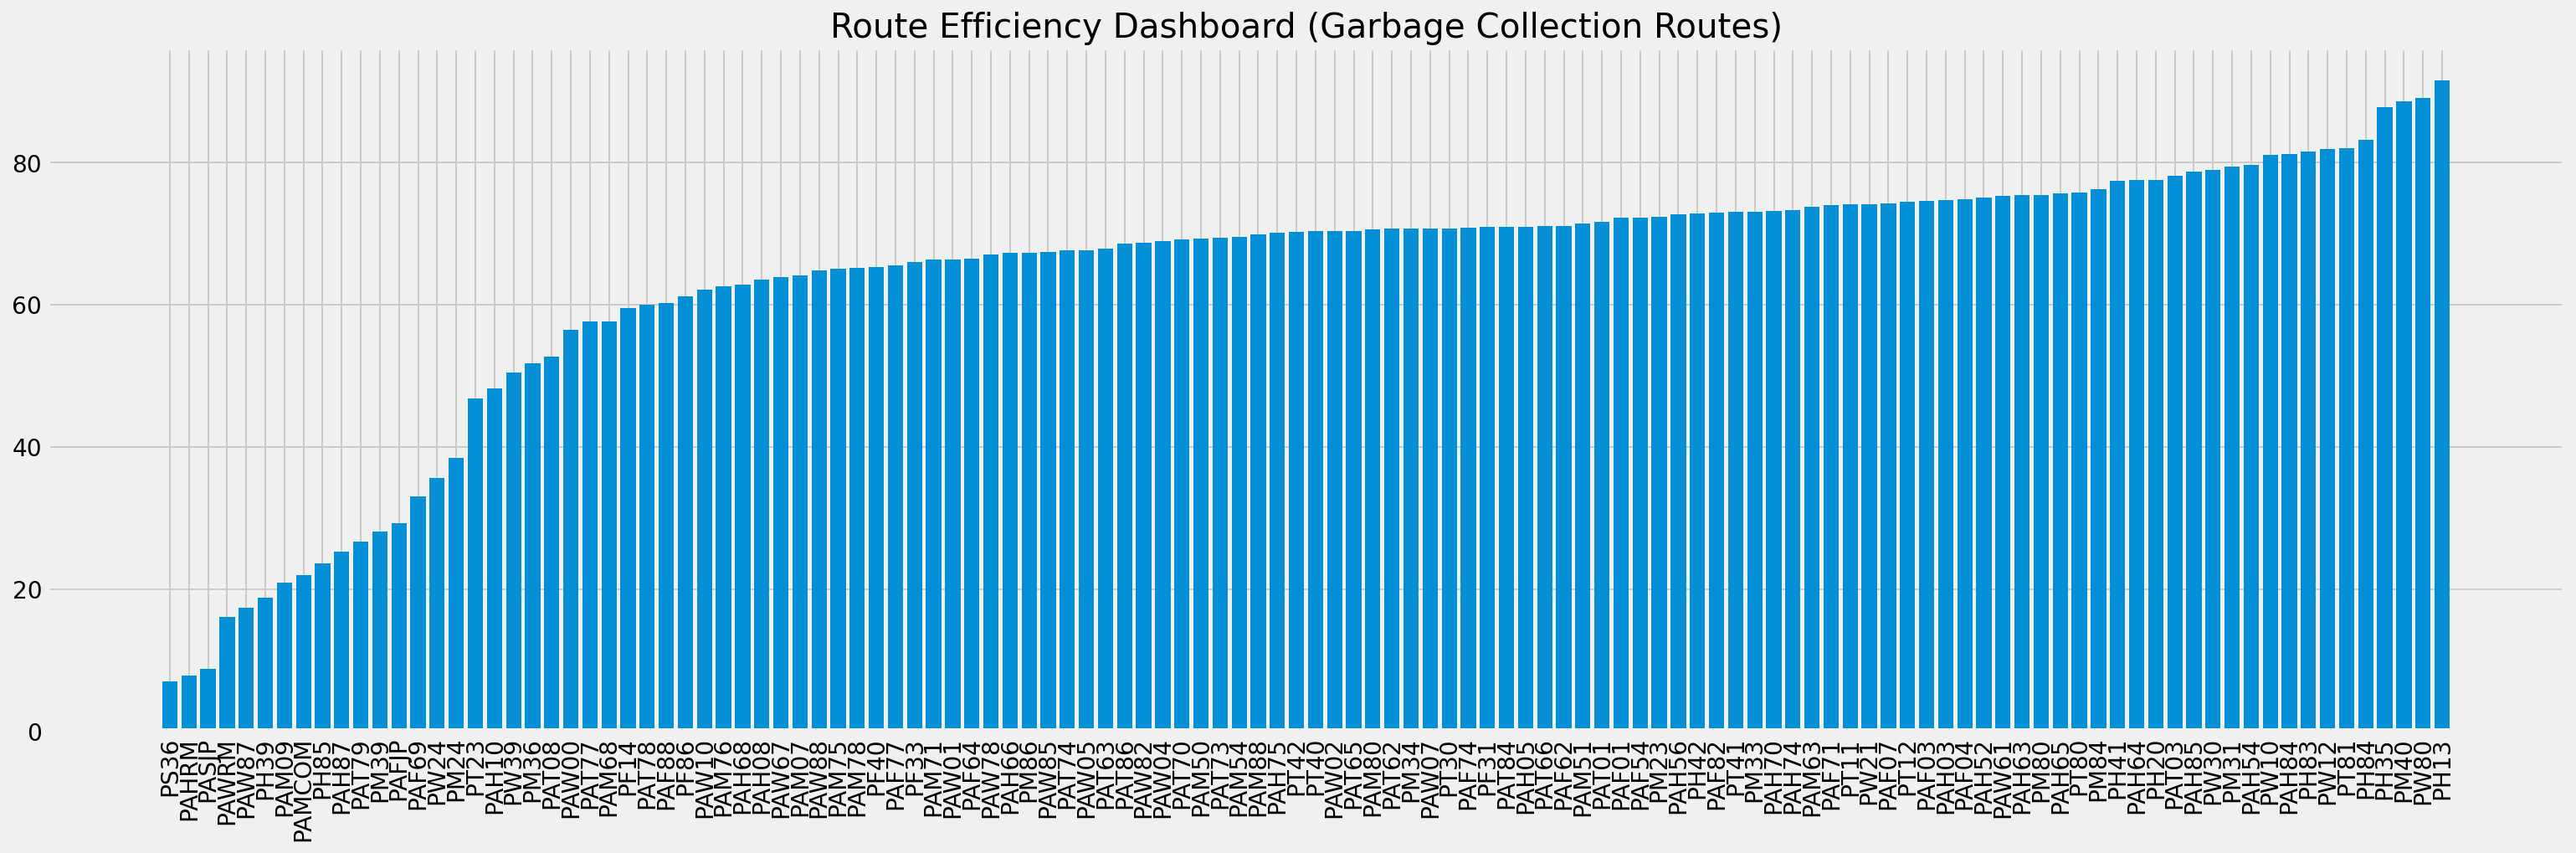

In [ ]:
plt.rcParams['figure.figsize'] = (24,7)
for i, row in modeling_df[modeling_df.route_type == 'GARBAGE COLLECTION'].groupby(['route_number', 'route_type'])[['route_type', 'capacity']].mean().sample(120).sort_values('capacity').reset_index().iterrows():
  plt.bar(row.route_number, row.capacity, color='C0')
plt.xticks(rotation=90)
plt.title('Route Efficiency Dashboard (Garbage Collection Routes)');

## 👓 References


[1] Quintili A., Castellani B. "The Energy and Carbon Footprint of an Urban Waste Collection Fleet: A Case Study in Central Italy" Department of Engineering, CIRIAF, University of Perugia  
[2] [Texas Waste Management Master Plan for Zero Waste 2040](https://www.austintexas.gov/sites/default/files/files/Trash_and_Recycling/MasterPlan_Final_12.30.pdf)

## ⏭️ Appendix
NaN